In [2]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr; xr.set_options(display_style='text') 
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from tools.wrfHrTools import *
from tools.generalTools import qsat,humidsat
from orographicConvectionTheory.orographicConvectionTheory import *
from orographicPrecipitation.observationsAndERA5.linearWaveModels import linear_w_1layer,linear_w_2layer,linear_w_generalized,w_to_zeta,w_to_Tprime
from orographicPrecipitation.observationsAndERA5.mountainUtils import *; from tools.generalTools import *; from tools.BLtools import *

SCRATCH='/global/cscratch1/sd/qnicolas/'

import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

import wrf
from scipy.interpolate import interp1d

In [3]:
def interp_z_full(sim,var,zlevs,staggered=False,**x_kwargs):
    var_s = change_coords_eta(sim,var,staggered=staggered,**x_kwargs)
    var_z=np.zeros((len(var_s.Time),len(zlevs),len(var_s.distance_from_mtn)))
    for i in range(var_z.shape[0]):
        if i%10==0:
            print(i, end=' ')
        var_z[i] = interp_eta_to_z(sim,var_s.isel(Time=i),zlevs=zlevs,staggered=staggered)
    var_z = xr.DataArray(var_z,coords={'Time':var_s.Time,'z':zlevs,'distance_from_mtn':var_s.distance_from_mtn},dims=['Time','z','distance_from_mtn'])
    return var_z

def zinterp(sim,varname,staggered,**x_kwargs):
    varmean_s = change_coords_eta(sim,sim[varname].mean('south_north'),staggered=staggered,**x_kwargs)
    return interp_eta_to_z(sim,varmean_s.squeeze(),zlevs=np.arange(0.,30e3,200.),staggered=staggered)
def get_temp_z(sim,**x_kwargs):
    temp = (sim.T+300)*((sim.PB+sim.P)/1e5)**0.286
    temp_s = change_coords_eta(sim,temp.mean('south_north'),staggered=False,**x_kwargs)
    return interp_eta_to_z(sim,temp_s.squeeze(),zlevs=np.arange(0.,30e3,200.),staggered=False)

def prime(var):
    return (var-var.isel(distance_from_mtn=0))

In [3]:
hill2d_lowdamp = xr.open_dataset("/global/cscratch1/sd/qnicolas/wrfdata/saved/idealized_gravitywaves/wrfout_d01_1970-01-01_00:00:00_lowdamp")
hill2d = xr.open_dataset("/global/cscratch1/sd/qnicolas/wrfdata/saved/idealized_gravitywaves/wrfout_d01_1970-01-01_00:00:00")
hill2d_wide = xr.open_dataset("/global/cscratch1/sd/qnicolas/wrfdata/saved/idealized_gravitywaves/smalldomain_idealtopo_ghatssounding_wrfout_d01")

x_kwargs={'center':100,'flip_x':False,'dx':2}
wmean_z_ld = zinterp(hill2d_lowdamp.isel(Time=[-1]),'W',True,**x_kwargs)
tmean_z_ld = get_temp_z(hill2d_lowdamp.isel(Time=[-1]),**x_kwargs)
#tmean_z_ld = zinterp(hill2d_lowdamp,'T',False,**x_kwargs)
wmean_z = zinterp(hill2d.isel(Time=[-1]),'W',True,**x_kwargs)
tmean_z = get_temp_z(hill2d.isel(Time=[-1]),**x_kwargs)
wmean_z_wide = zinterp(hill2d_wide.isel(Time=[-1]),'W',True,**x_kwargs)
tmean_z_wide = get_temp_z(hill2d_wide.isel(Time=[-1]),**x_kwargs)


In [4]:
z0 = (hill2d_wide.PHB[-1,:,0,0]+hill2d_wide.PH[-1,:,0,0])/9.81

In [5]:
def levs(wmax,n):
    x=np.linspace(-wmax**(1/n),wmax**(1/n),40)
    return np.sign(x)*np.abs(x)**n
wlevs=levs(0.4,2)
wticks=[-.5,-.4,-.1,0.,.1,.4,.5]

# 2D case with gaussian hill and constant wind

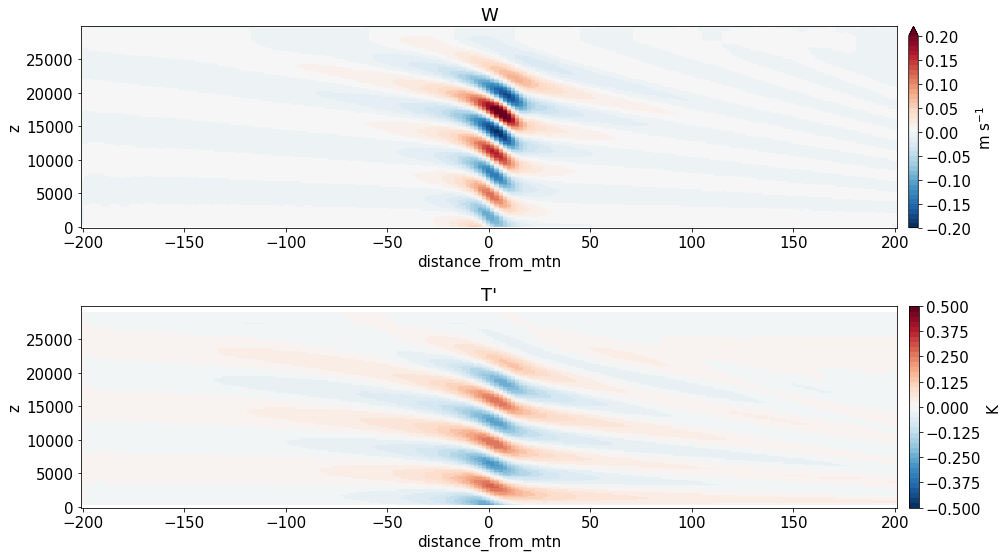

In [7]:
fig,axs=plt.subplots(2,1,figsize=(15,8))
wmean_z.plot(ax=axs[0],x='distance_from_mtn',levels=np.linspace(-0.2,0.2,41),cbar_kwargs={ 'label':r'm s$^{-1}$','pad':.012})
prime(tmean_z).plot(ax=axs[1],x='distance_from_mtn',levels=np.linspace(-0.5,0.5,41),cbar_kwargs={ 'label':r'K','pad':.012})
axs[0].set_title("W")
axs[1].set_title("T'")
fig.tight_layout()

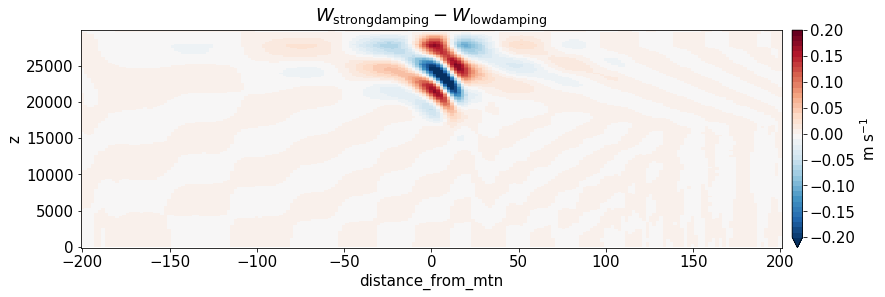

In [8]:
_,ax=plt.subplots(1,1,figsize=(15,4))
(wmean_z-wmean_z_ld).plot(ax=ax,x='distance_from_mtn',levels=np.linspace(-0.2,0.2,41),cbar_kwargs={ 'label':r'm s$^{-1}$','pad':.012})
ax.set_title(r"$W_{\mathrm{strongdamping}}-W_{\mathrm{low damping}}$");None

In [9]:
xx = np.arange(-200,201,0.5)
hx = 100/(1+(xx/10)**2)
wlin=linear_w_1layer(xx*1e3,hx,np.array(z0),10,0.01)
wlin=wlin.assign_coords(z=1e3*wlin.altitude)

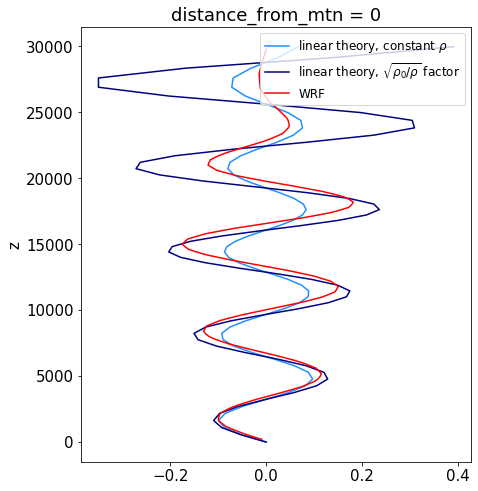

In [11]:
fig,ax=plt.subplots(1,1,figsize=(7,8))
wlin_constrho = wlin.sel(distance_from_mtn=0,method='nearest')
rho0=1.2; rho = rho0*np.exp(-9.81/(287.*290.)*wlin_constrho.z)
wlin_constrho.plot(ax=ax,y='z',label=r'linear theory, constant $\rho$',color='dodgerblue')
(np.sqrt(rho0/rho)*wlin_constrho).plot(ax=ax,y='z',label=r'linear theory, $\sqrt{\rho_0/\rho}$ factor',color='navy')
wmean_z.sel(distance_from_mtn=0,method='nearest').plot(ax=ax,y='z',label='WRF',color='r')
ax.legend(fontsize=12,loc=1)

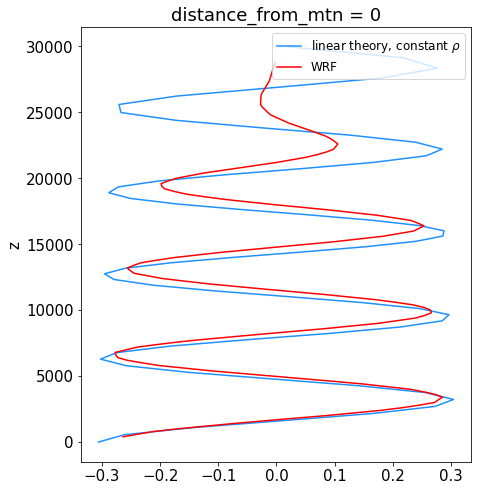

In [24]:
fig,ax=plt.subplots(1,1,figsize=(7,8))
Tprime_constrho = w_to_Tprime(wlin,10.,0.01).sel(distance_from_mtn=0,method='nearest')
Tprime_constrho.plot(ax=ax,y='z',label=r'linear theory, constant $\rho$',color='dodgerblue')
#Tprime = w_to_Tprime((np.sqrt(rho0/rho)*wlin).transpose('distance_from_mtn','altitude'),10.,0.01).sel(distance_from_mtn=0,method='nearest')
#Tprime.plot(ax=ax,y='z',label=r'linear theory, $\sqrt{\rho_0/\rho}$ factor',color='navy')
prime(tmean_z).sel(distance_from_mtn=0,method='nearest').plot(ax=ax,y='z',label='WRF',color='r')
ax.legend(fontsize=12,loc=1)

# Wind profile from Western Ghats

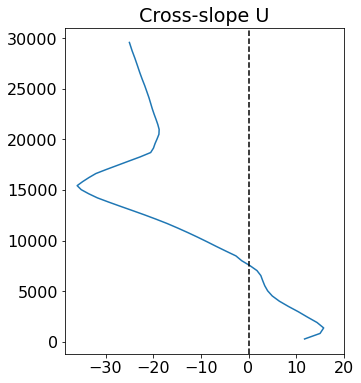

In [83]:
_,ax=plt.subplots(1,1,figsize=(5,6))
ax.plot(hill2d_wide.U[-1,:,0,0],wrf.destagger(z0,0))
ax.set_title("Cross-slope U")
ax.axvline(0.,color='k',linestyle='--')
ax.set_xticks(range(-30,21,10));None

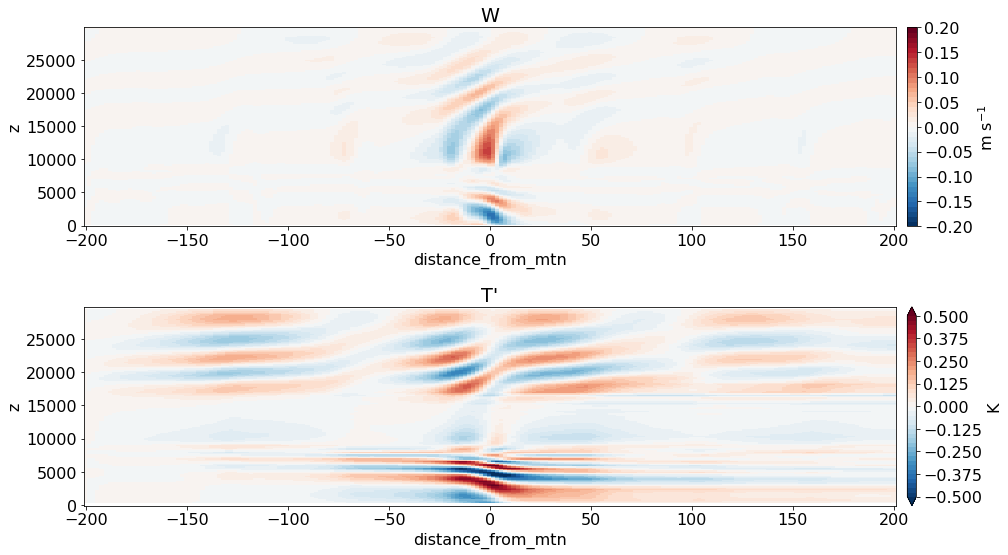

In [84]:
fig,axs=plt.subplots(2,1,figsize=(15,8))
wmean_z_wide.plot(ax=axs[0],x='distance_from_mtn',levels=np.linspace(-0.2,0.2,41),cbar_kwargs={ 'label':r'm s$^{-1}$','pad':.012})
prime(tmean_z_wide).plot(ax=axs[1],x='distance_from_mtn',levels=np.linspace(-0.5,0.5,41),cbar_kwargs={ 'label':r'K','pad':.012})
axs[0].set_title("W")
axs[1].set_title("T'")
fig.tight_layout()

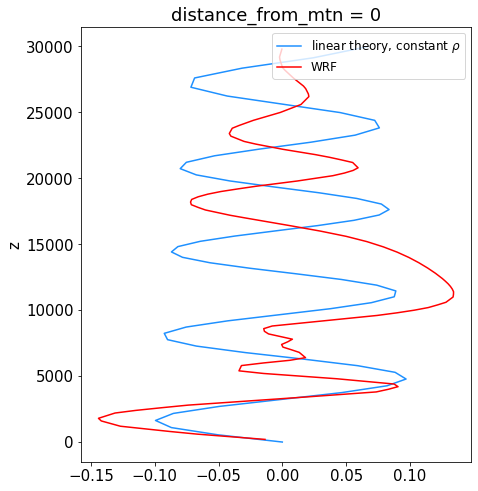

In [25]:
fig,ax=plt.subplots(1,1,figsize=(7,8))
wlin_constrho = wlin.sel(distance_from_mtn=0,method='nearest')
wlin_constrho.plot(ax=ax,y='z',label=r'linear theory, constant $\rho$',color='dodgerblue')
wmean_z_wide.sel(distance_from_mtn=0,method='nearest').plot(ax=ax,y='z',label='WRF',color='r')
ax.legend(fontsize=12,loc=1)

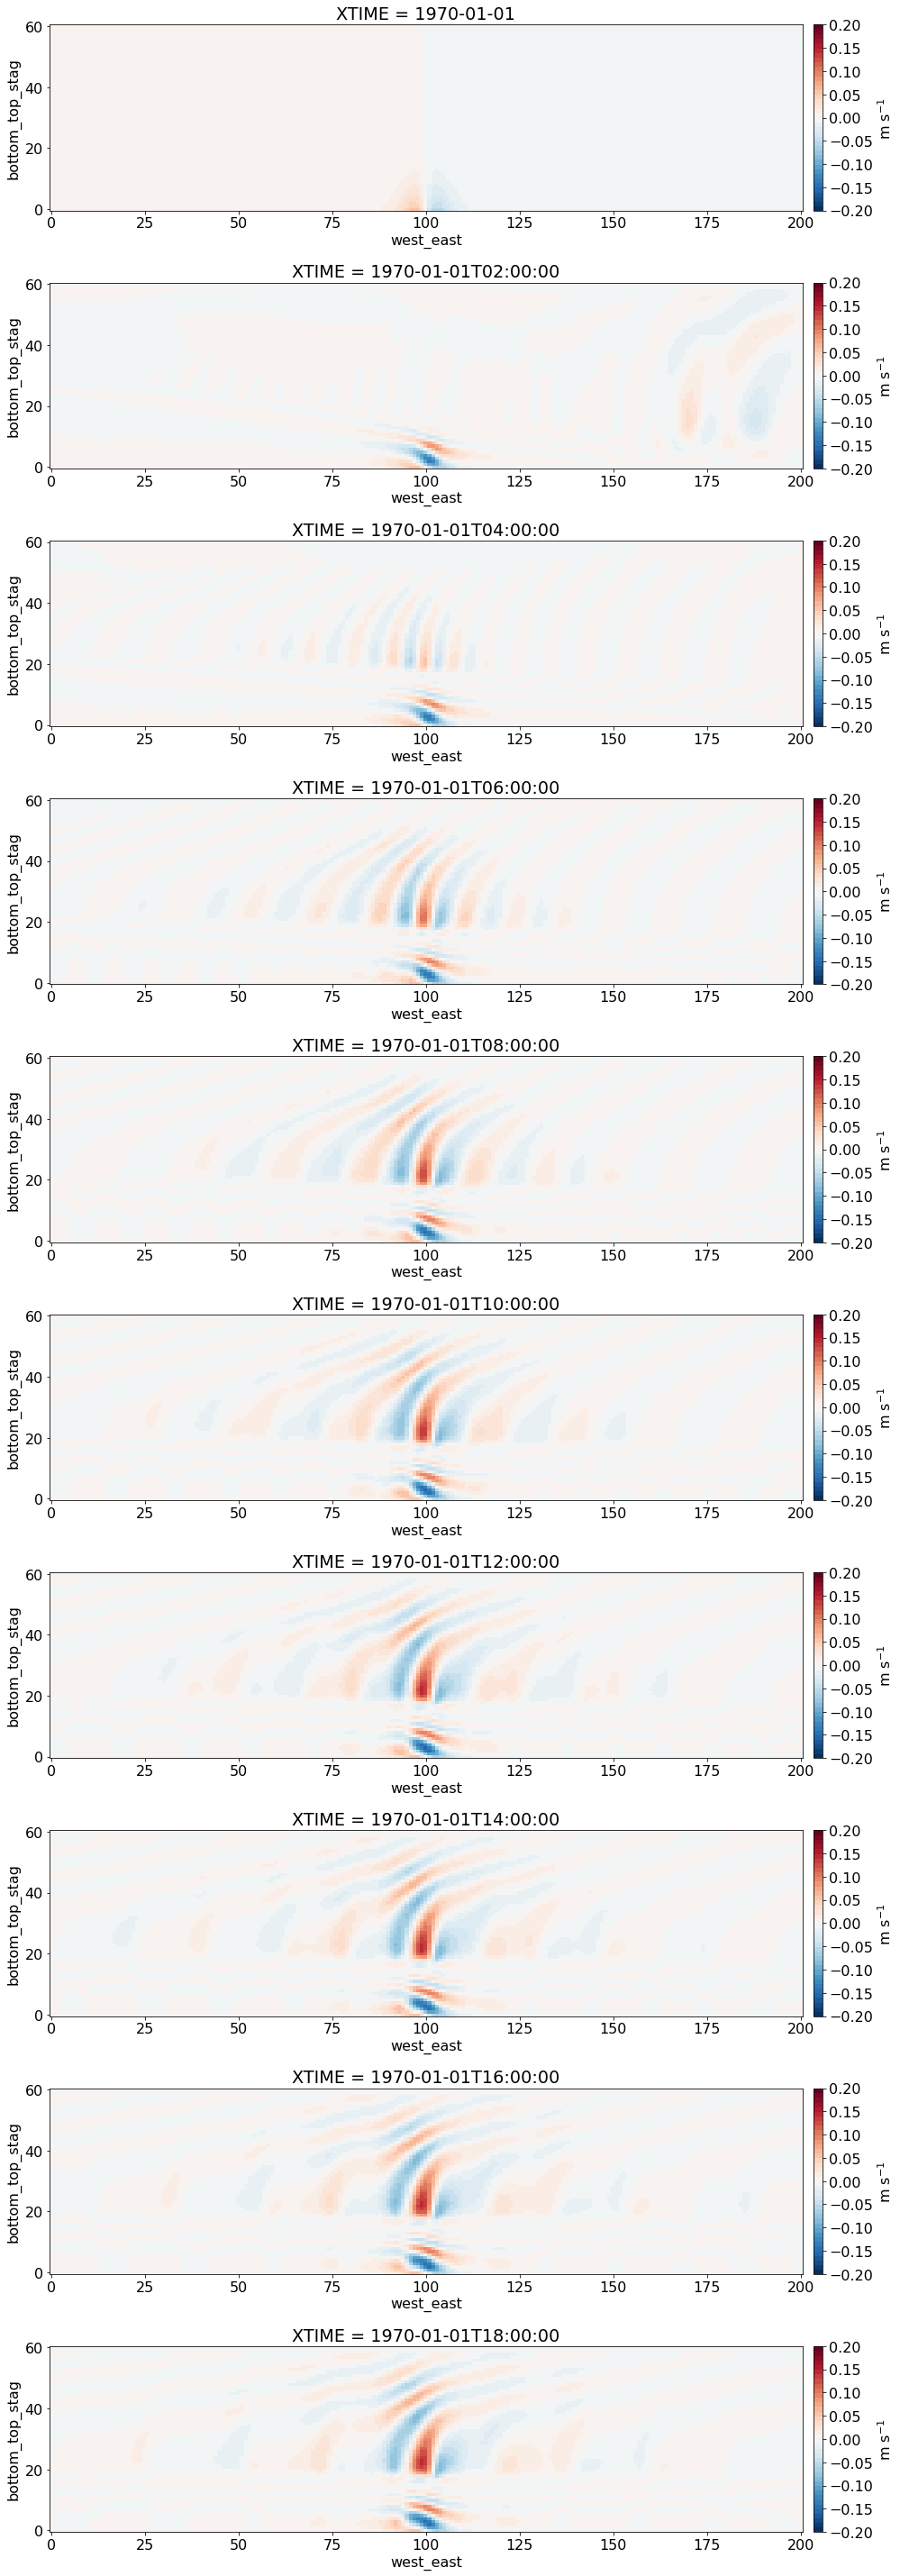

In [37]:
fig,axs=plt.subplots(10,1,figsize=(15,40))
for i in range(10):
    hill2d_wide.isel(Time=2*i).W.mean('south_north').plot(ax=axs[i],x='west_east',levels=np.linspace(-0.2,0.2,41),cbar_kwargs={ 'label':r'm s$^{-1}$','pad':.012})
fig.tight_layout()

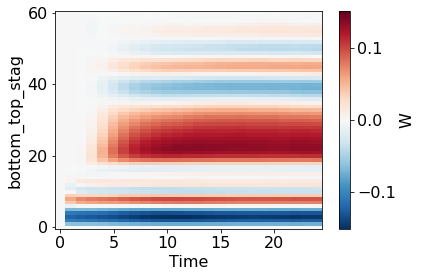

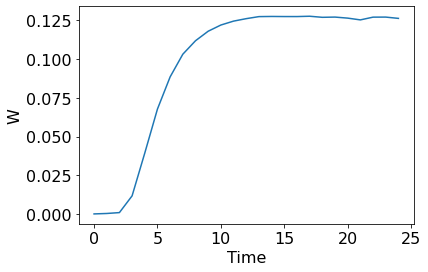

In [133]:
Whov = hill2d_wide.W.isel(west_east=100).mean('south_north')
Whov.plot(x='Time')
plt.figure()
Whov.isel(bottom_top_stag=25).plot()

# Large domain with Ghats topography and sounding

In [6]:
ghats_ideal = xr.open_dataset("/global/cscratch1/sd/qnicolas/wrfdata/saved/gw.wrf.2D.60lev.10km/wrfout_d01_1970-01-01_00_00_00")
x_kwargs={'center':314,'flip_x':False,'dx':10}
z0 = wrf.destagger((ghats_ideal.PH[-1,:,:,0].mean('south_north') + ghats_ideal.PHB[-1,:,0,0])/9.81,0)
p0 = (ghats_ideal.P[-1,:,:,0].mean('south_north') + ghats_ideal.PB[-1,:,0,0])



In [5]:
#%time ghats_ideal_temp = ((ghats_ideal.T+300)*((ghats_ideal.PB+ghats_ideal.P)/1e5)**0.286).mean('south_north')
#ghats_ideal_temp.to_netcdf("/global/cscratch1/sd/qnicolas/wrfdata/saved/gw.wrf.2D.60lev.10km/diags/wrf.TEMP.days0-10.nc")

CPU times: user 5.58 s, sys: 5.08 s, total: 10.7 s
Wall time: 13.5 s


In [48]:
#%%time # 1min30 per variable
#zlevs=np.arange(0.,20e3,200.)
#ghats_ideal_temp=xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/gw.wrf.2D.60lev.10km/diags/wrf.TEMP.days0-10.nc")
#ghats_ideal_temp_z = interp_z_full(ghats_ideal,ghats_ideal_temp,zlevs,**x_kwargs)
#ghats_ideal_temp_z.to_netcdf("/global/cscratch1/sd/qnicolas/wrfdata/saved/gw.wrf.2D.60lev.10km/diags/wrf.TEMP.zinterp.days0-10.nc")

#ghats_ideal_theta_z = interp_z_full(ghats_ideal,300+ghats_ideal.T.mean('south_north'),zlevs,**x_kwargs)
#ghats_ideal_theta_z.to_netcdf("/global/cscratch1/sd/qnicolas/wrfdata/saved/gw.wrf.2D.60lev.10km/diags/wrf.THETA.zinterp.days0-10.nc")


0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 CPU times: user 45.8 s, sys: 49.4 s, total: 1min 35s
Wall time: 1min 35s


In [12]:
ghats_ideal_temp_z=xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/gw.wrf.2D.60lev.10km/diags/wrf.TEMP.zinterp.days0-10.nc")
p_equiv = interp1d(z0,p0,fill_value='extrapolate')(ghats_ideal_temp_z.z)

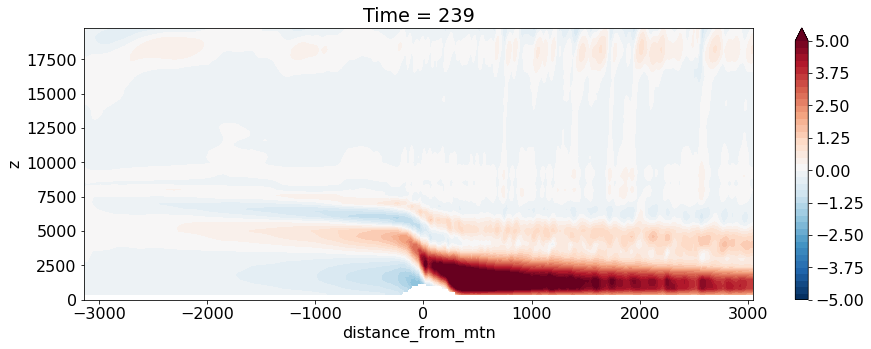

In [11]:
fig,ax=plt.subplots(1,1,figsize=(15,5))
prime(ghats_ideal_temp_z.isel(Time=-1)).plot.contourf(ax=ax,y='z',levels=np.linspace(-5,5,41))

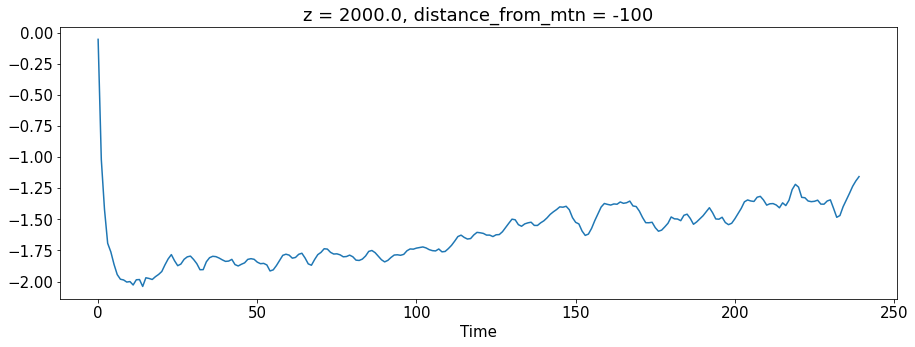

In [59]:
fig,ax=plt.subplots(1,1,figsize=(15,5))
prime(ghats_ideal_temp_z).sel(distance_from_mtn=-100,z=2000,method='nearest').plot(ax=ax)

Text(0.5, 1.0, 'Upstream U soundings, pressure levels')

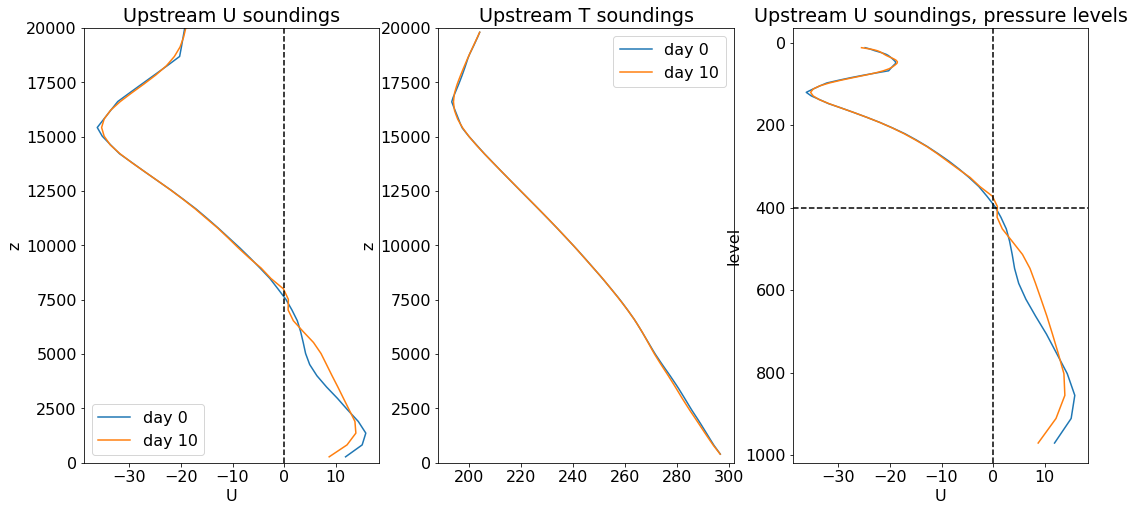

In [22]:
fig,axs=plt.subplots(1,3,figsize=(18,8))
ghats_ideal.U.assign_coords({'z':('bottom_top',z0)}).isel(Time=0,west_east_stag=0).mean('south_north').plot(ax=axs[0],y='z',label='day 0')
ghats_ideal.U.assign_coords({'z':('bottom_top',z0)}).isel(Time=-1,west_east_stag=0).mean('south_north').plot(ax=axs[0],y='z',label='day 10')
ghats_ideal_temp_z.isel(Time=0,distance_from_mtn=0).plot(ax=axs[1],y='z',label='day 0')
ghats_ideal_temp_z.isel(Time=-1,distance_from_mtn=0).plot(ax=axs[1],y='z',label='day 10')
axs[0].axvline(0.,color='k',linestyle='--')
for ax in axs[:2]:
    ax.legend()
    ax.set_ylim(0,20e3)
axs[0].set_title("Upstream U soundings")
axs[1].set_title("Upstream T soundings")

ghats_ideal.U.assign_coords({'level':('bottom_top',p0/100)}).isel(Time= 0,west_east_stag=0).mean('south_north').plot(ax=axs[2],y='level',yincrease=False,label='day 0')
ghats_ideal.U.assign_coords({'level':('bottom_top',p0/100)}).isel(Time=-1,west_east_stag=0).mean('south_north').plot(ax=axs[2],y='level',yincrease=False,label='day 10')
axs[2].axvline(0.,color='k',linestyle='--')
axs[2].axhline(400.,color='k',linestyle='--')
axs[2].set_title("Upstream U soundings, pressure levels")


In [23]:
orogm=xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc").Z.isel(time=0)/9.81
landmask=xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc").LSM.isel(time=0)
gpm_pr_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/GPM-IMERG-seasonalmean-200101-201812.nc")
era5100u=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.climatology.228_246_100u.2001-2018.nc")
era5100v=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.climatology.228_247_100v.2001-2018.nc")
climcapst_climatology = xr.open_zarr("/global/cscratch1/sd/qnicolas/CLIMCAPS_V2/monthly/L3_CLIMCAPS_QCC.air_temp.monthly.zarr").air_temp.groupby('time.month').mean(['time','orbit_pass'])

box = [68,85,7.5,17]  
angle = 90
precipitating_month = 7
mountaintop=900. # abscissa of mountain top within rotated frame

Ghatswide = MountainRange('ghatswide',box,"Western Ghats",angle,precipitating_month,mountaintop)
Ghatswide.set_2dvar('GPM_PR',gpm_pr_seasmean)
Ghatswide.set_2dvar('VAR_100U',era5100u)
Ghatswide.set_2dvar('VAR_100V',era5100v)
Ghatswide.set_2dvar('Z',orogm)
Ghatswide.set_3dvar('T',"128_130_t")
Ghatswide.set_othervar('CLIMCAPS_T',sel_box_month(climcapst_climatology,Ghatswide.box,Ghatswide.pr_month).assign_coords(level=climcapst_climatology.air_pres/100).swap_dims({'air_pres':'level'}))

deeptmean_p = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.T_PL.days100-250.nc")
wrf_tprime = deeptmean_p - deeptmean_p[:,2000:2200].mean('west_east')
pres_wrf = np.array([99000,97500,95000,92500,90000,87500,85000,82500,80000,77500,75000,70000,65000,60000,55000,50000,45000,40000,35000,30000,25000,22500,20000,17500,15000,12500,10000,7500,5000])/100.
wrf_tprime = wrf_tprime.where(wrf_tprime>-10).assign_coords({'pressure':('num_press_levels_stag',pres_wrf),'distance_from_mtn':(1635-wrf_tprime.west_east)*3}).swap_dims({'num_press_levels_stag':'pressure','west_east':'distance_from_mtn'})[1:]



/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [17]:
def crossslope_avg_bis(var):
    m=len(var.y)
    return var.isel(y=slice(int(0.35*m),int(0.65*m))).mean('y')

def plot_xz_bis(ax,region,varname,pert=False,fact=1,**plot_kwargs):
    if pert:
        cv=crossslope_avg_bis(fact*region.vars_rot[varname])
        (cv-cv.sel(x=slice(cv.x[0],cv.x[0]+200)).mean('x')).plot.contourf(ax=ax,yincrease=False,**plot_kwargs)
    else:
        crossslope_avg_bis(fact*region.vars_rot[varname]).plot.contourf(ax=ax,yincrease=False,**plot_kwargs)
    p_sfc = crossslope_avg_bis(999-region.vars_rot['Z']/(1.1*9.81))
    p_sfc.plot(ax=ax,color='k')
    ax.fill_between(p_sfc.x,0*p_sfc+1000.,p_sfc,color='w')

In [22]:
ghats_ideal_tprime_z = prime(ghats_ideal_temp_z.isel(Time=-1)).assign_coords({'level':('z',p_equiv/100.),'x':ghats_ideal_temp_z.distance_from_mtn+100})
ghats_ideal_tprime_z = ghats_ideal_tprime_z.swap_dims({'distance_from_mtn':'x'})
ghats_ideal_tprime_z = ghats_ideal_tprime_z - ghats_ideal_tprime_z.sel(x=-900,method='nearest')


Ghats_T=crossslope_avg_bis(Ghatswide.vars_rot['T'])
Ghats_Tprime=Ghats_T-Ghats_T.sel(x=slice(Ghats_T.x[0],Ghats_T.x[0]+200)).mean('x')

(-900.0, 1000.0)

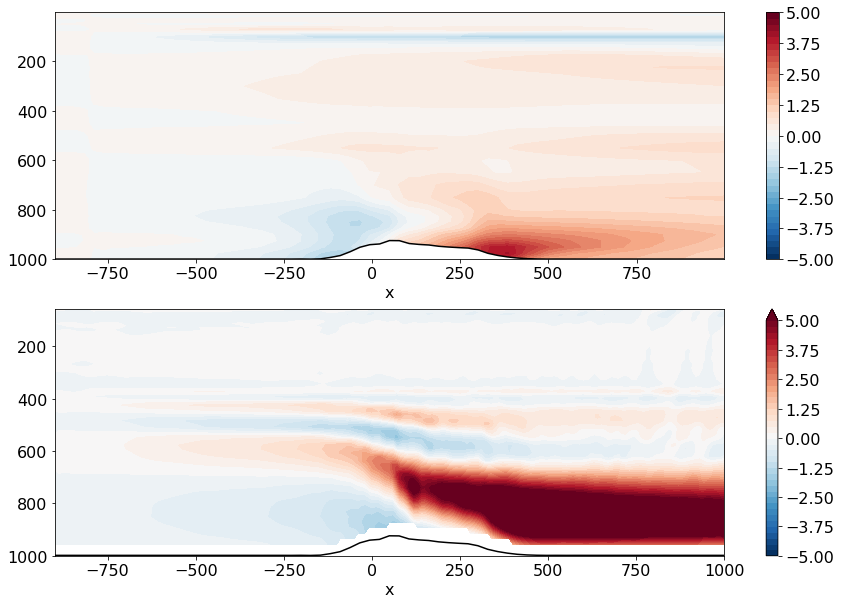

In [167]:
fig,axs = plt.subplots(2,1,figsize=(15,10))
plot_xz_bis(axs[0],Ghatswide,'T',pert=True,levels=np.linspace(-5,5,41))

ghats_ideal_tprime_z.plot.contourf(ax=axs[1],x='x',y='level',yincrease=False,levels=np.linspace(-5,5,41))
p_sfc = crossslope_avg_bis(999-Ghatswide.vars_rot['Z']/(1.1*9.81))
p_sfc.plot(ax=axs[1],color='k')
axs[1].set_xlim(-900,1000)

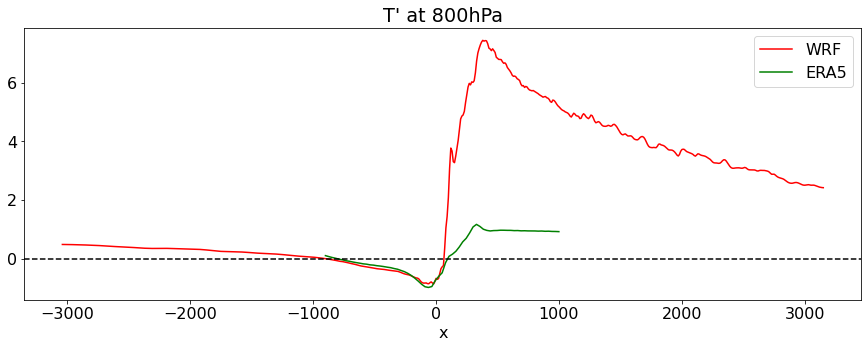

In [169]:
fig,ax=plt.subplots(1,1,figsize=(15,5))
ghats_ideal_tprime_z.swap_dims({'z':'level'}).sel(level=800,method='nearest').plot(ax=ax,color='r',label='WRF')
(Ghats_Tprime     ).sel(level=800,method='nearest').plot(ax=ax,color='g',label='ERA5')
ax.axhline(0.,color='k',linestyle='--')
ax.set_title("T' at 800hPa")
ax.legend()

(-0.6, 0.6)

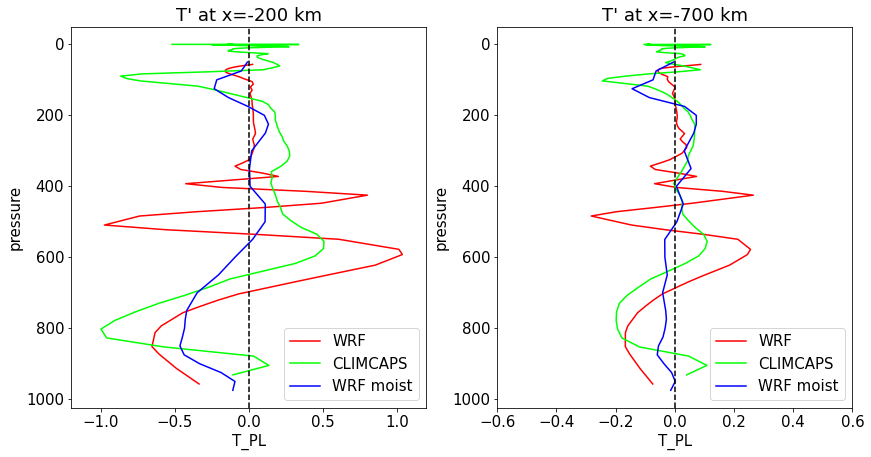

In [72]:
locs=(-200,-700)
fig,axs=plt.subplots(1,len(locs),figsize=(7*len(locs),7))
for ax,x0 in zip(axs,locs):
    ghats_ideal_tprime_z.sel(x=x0).plot(ax=ax,y='level',color='r',label='WRF')
    #plot_z(ax,Ghatswide,'T',x0,pert=True,color='g',label='ERA5')
    plot_z(ax,Ghatswide,'CLIMCAPS_T',x0,pert=True,color='lime',label='CLIMCAPS')
    
    wrf_tprime.sel(distance_from_mtn=x0,method='nearest').plot(ax=ax,y='pressure',yincrease=False,color='b',label='WRF moist')
    ax.axvline(0.,color='k',linestyle='--')
    ax.set_title("T' at x=%i km"%x0)
    ax.legend()
    
axs[0].set_xlim(-1.2,1.2)
axs[1].set_xlim(-0.6,0.6)

In [25]:
zlevs=np.arange(0.,20e3,200.)
ghats_ideal_w_z = interp_z_full(ghats_ideal,ghats_ideal.W[-100:].mean('south_north'),zlevs,staggered=True,**x_kwargs)
ghats_ideal_w_z = ghats_ideal_w_z.assign_coords({'level':('z',p_equiv/100.)})


0 10 20 30 40 50 60 70 80 90 

(-1000.0, 1000.0)

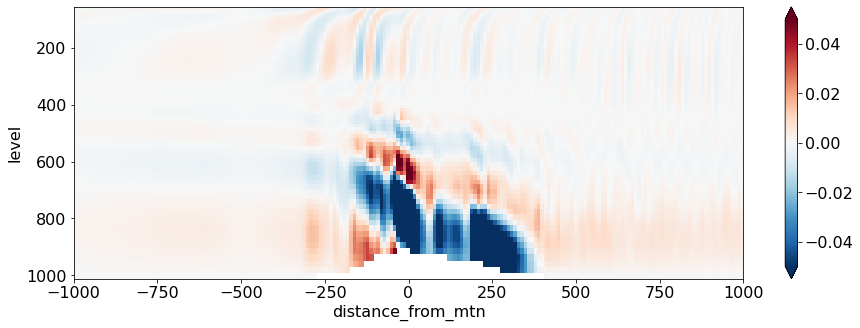

In [26]:
plt.figure(figsize=(15,5))
ghats_ideal_w_z.mean(['Time']).plot(y='level',yincrease=False,vmin=-0.05,vmax=0.05,cmap=plt.cm.RdBu_r)
plt.xlim(-1000,1000)

# Comparing Ghats/Andes/Vietnam topography in ERA5 and CMIP6 models

In [55]:
#gmtedorog    = xr.open_dataset("/global/cscratch1/sd/qnicolas/precipmodel/GMTED2010_15n015_00625deg.nc").elevation
#gmtedorog=gmtedorog.assign_coords({'longitude':gmtedorog.longitude%360}).sortby('longitude')
era5orog     = xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc").Z.isel(time=0)/9.81
ecearth_orog = xr.open_dataset("/global/cfs/projectdirs/m3522/cmip6/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3/ssp245/r2i1p1f1/Emon/orog/gr/v20191022/orog_Emon_EC-Earth3_ssp245_r2i1p1f1_gr_205401-205412.nc").orog[0]
cesm2_orog   = xr.open_dataset("/global/cfs/projectdirs/m3522/cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp585/r1i1p1f1/fx/orog/gn/v20190730/orog_fx_CESM2_ssp585_r1i1p1f1_gn.nc").orog


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'orog' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


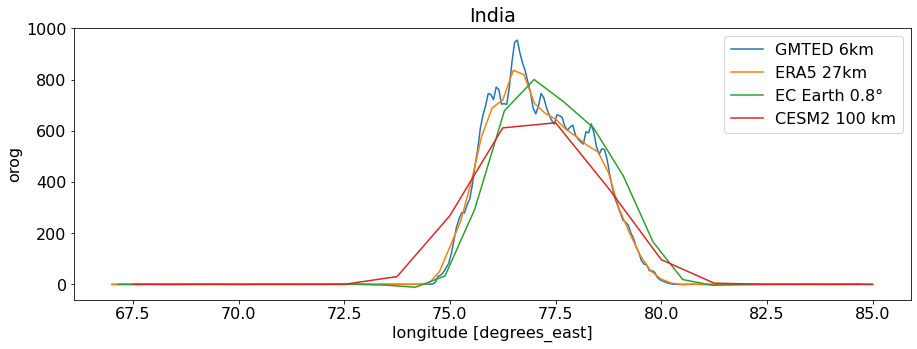

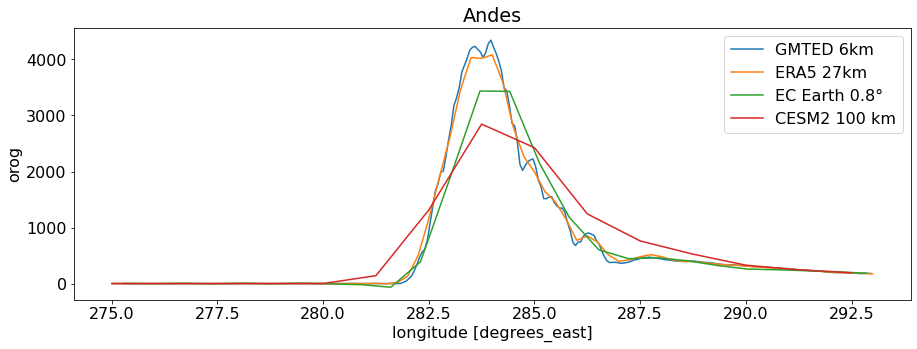

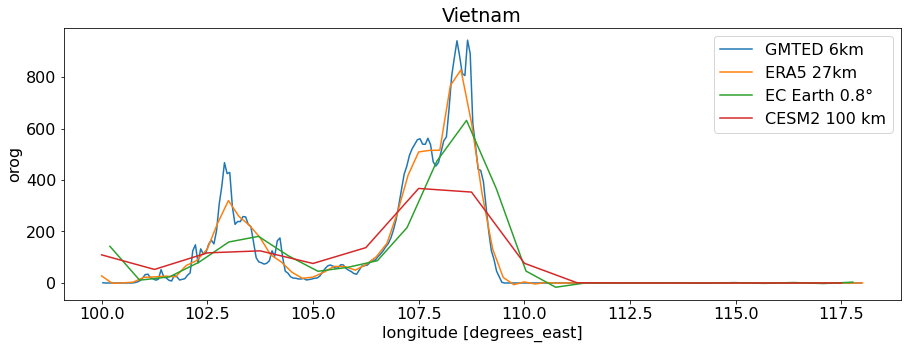

In [142]:
for box,name in (([67,85,14,11],'India'),([275,293,-10,-12],'Andes'),([100,118,13,12],'Vietnam')):
    plt.figure(figsize=(15,5))
    box2=box.copy()
    box2[2],box2[3]=box2[3],box2[2]
    sel_box_month(gmtedorog   ,box,0).mean('latitude').plot(label='GMTED 6km')
    sel_box_month(era5orog    ,box2,0).mean('latitude').plot(label='ERA5 27km')
    sel_box_month(ecearth_orog,box,0,'lon','lat').mean('lat').plot(label='EC Earth 0.8°')
    sel_box_month(cesm2_orog  ,box,0,'lon','lat').mean('lat').plot(label='CESM2 100 km')
    plt.legend()
    plt.title(name)

In [14]:
era5p = xr.open_dataset('/global/cfs/projectdirs/m3522/cmip6/ERA5/e5.oper.an.pl.monthly/e5.oper.an.pl.128_130_t.ll025sc.197901.nc').level

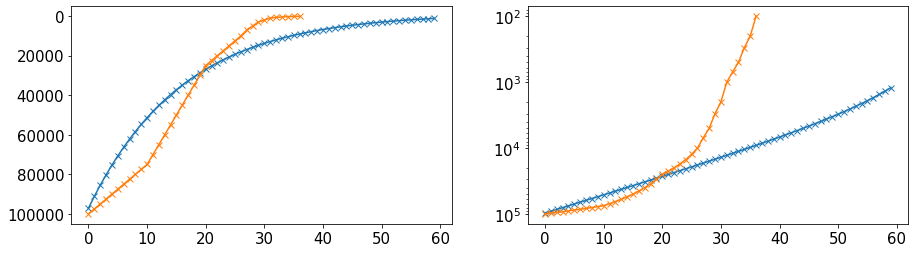

In [29]:
_,(ax1,ax2) = plt.subplots(1,2,figsize=(15,4))
for ax in ax1,ax2:
    ax.plot(p0,'-x')
    ax.plot(era5p[::-1]*100,'-x')
    ax.invert_yaxis()
ax2.set_yscale('log')

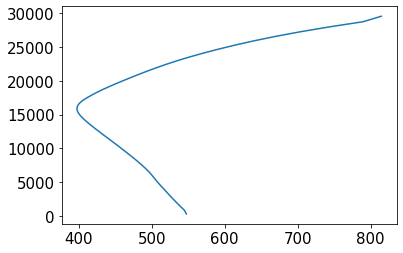

In [28]:
plt.plot(np.gradient(z0),z0)

# Runs with lower res

In [42]:
ghats_ideal_25 = xr.open_dataset("/global/cscratch1/sd/qnicolas/wrfdata/saved/gw.wrf.2D.60lev.25km/wrfout_d01_1970-01-01_00_00_00")
x_kwargs_25={'center':125,'flip_x':False,'dx':25}
ghats_ideal_100 = xr.open_dataset("/global/cscratch1/sd/qnicolas/wrfdata/saved/gw.wrf.2D.60lev.100km/wrfout_d01_1970-01-01_00_00_00")
x_kwargs_100={'center':30,'flip_x':False,'dx':100}

In [43]:
def compute_wtz(sim,**x_kwargs):
    sim = sim.isel(Time=slice(-2,-1))
    temp = ((sim.T+300)*((sim.PB+sim.P)/1e5)**0.286).mean('south_north')
    zlevs=np.arange(0.,20e3,200.)
    temp_z = interp_z_full(sim,temp,zlevs,**x_kwargs)
    
    w_z = interp_z_full(sim,sim.W.mean('south_north'),zlevs,staggered=True,**x_kwargs)
    w_z = w_z.assign_coords({'level':('z',p_equiv/100.)})

    return w_z[0],temp_z[0]
ghats_ideal_w_25_z,ghats_ideal_temp_25_z = compute_wtz(ghats_ideal_25,**x_kwargs_25)
ghats_ideal_w_100_z,ghats_ideal_temp_100_z = compute_wtz(ghats_ideal_100,**x_kwargs_100)

0 0 0 0 

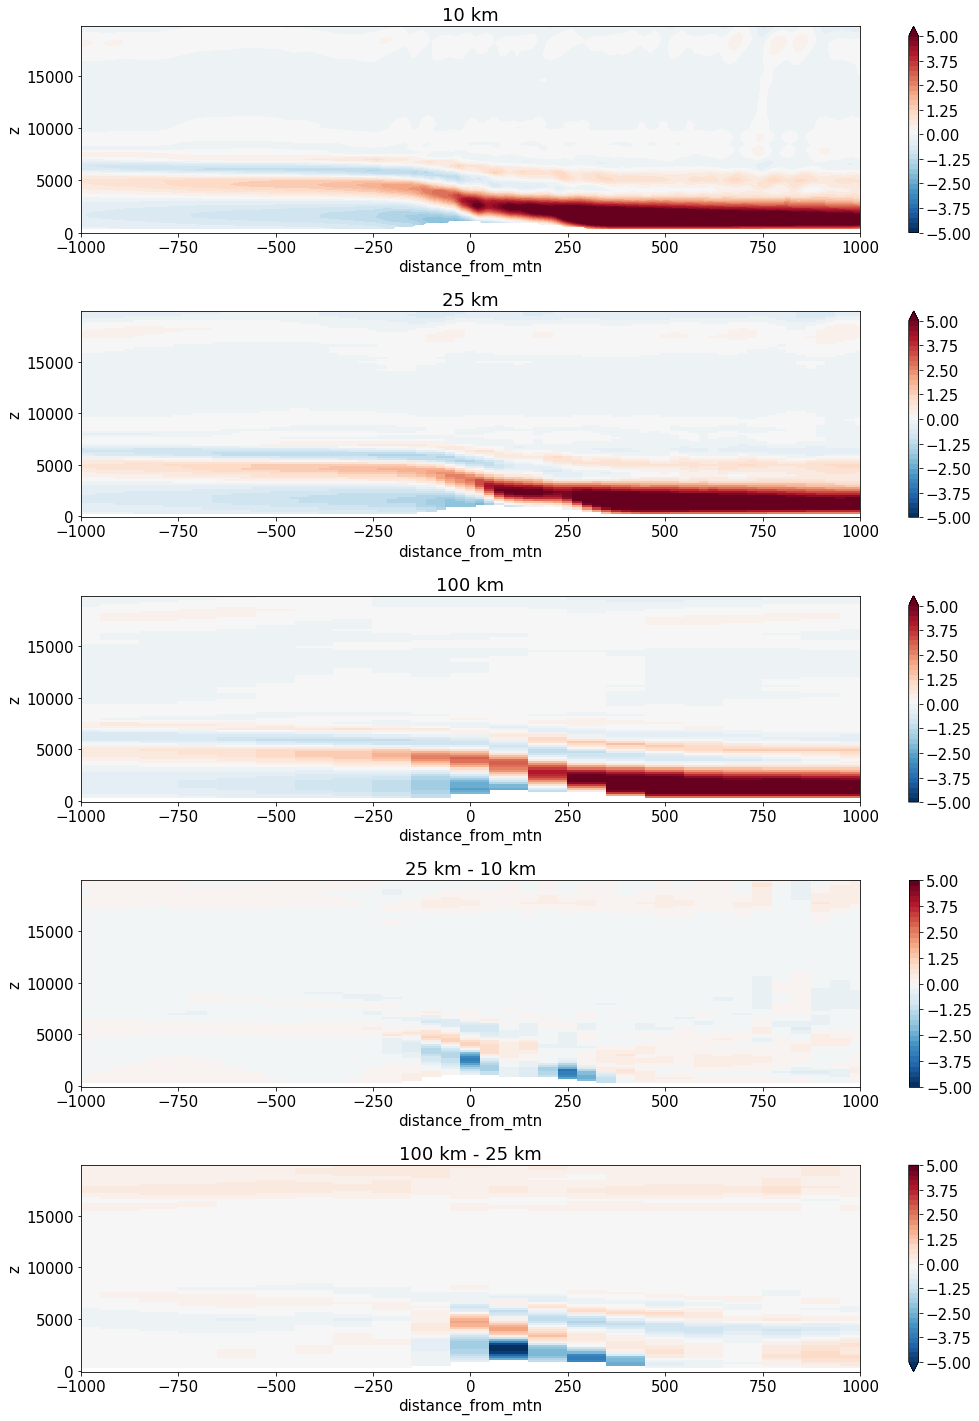

In [53]:
fig,axs=plt.subplots(5,1,figsize=(15,20))
prime(ghats_ideal_temp_z.isel(Time=-1)).plot.contourf(ax=axs[0],y='z',levels=np.linspace(-5,5,41))
prime(ghats_ideal_temp_25_z).plot(ax=axs[1],y='z',levels=np.linspace(-5,5,41))
prime(ghats_ideal_temp_100_z).plot(ax=axs[2],y='z',levels=np.linspace(-5,5,41))
(ghats_ideal_temp_25_z-ghats_ideal_temp_z.isel(Time=-1)).plot(ax=axs[3],y='z',levels=np.linspace(-5,5,41))
(ghats_ideal_temp_100_z-ghats_ideal_temp_25_z).plot(ax=axs[4],y='z',levels=np.linspace(-5,5,41))
for ax,ttl in zip(axs,("10 km","25 km","100 km","25 km - 10 km","100 km - 25 km")):
    ax.set_xlim(-1000,1000)
    ax.set_title(ttl)
fig.tight_layout()

In [61]:
ghats_ideal_25_topo = change_coords_sfc(ghats_ideal_25.HGT[-1,0],**x_kwargs_25)
ghats_ideal_100_topo = change_coords_sfc(ghats_ideal_100.HGT[-1,0],**x_kwargs_100)

(67.0, 85.0)

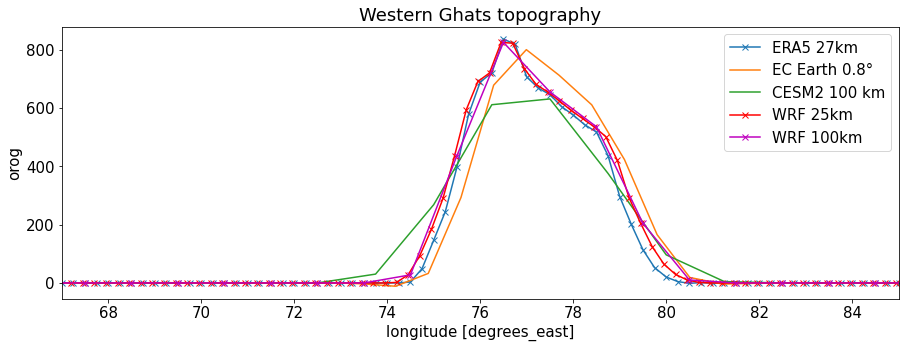

In [70]:
box,name = [67,85,14,11],'Western Ghats topography'
plt.figure(figsize=(15,5))
box2=box.copy()
box2[2],box2[3]=box2[3],box2[2]
sel_box_month(era5orog    ,box2,0).mean('latitude').plot(marker='x',label='ERA5 27km')
sel_box_month(ecearth_orog,box,0,'lon','lat').mean('lat').plot(marker='',label='EC Earth 0.8°')
sel_box_month(cesm2_orog  ,box,0,'lon','lat').mean('lat').plot(marker='',label='CESM2 100 km')
plt.plot((ghats_ideal_25_topo.distance_from_mtn/100+76.2),ghats_ideal_25_topo,'-xr',label='WRF 25km')
plt.plot((ghats_ideal_100_topo.distance_from_mtn/100+75.5),ghats_ideal_100_topo,'-xm',label='WRF 100km')
plt.legend()
plt.title(name)
plt.xlim(67,85)